https://www.youtube.com/watch?v=4OlvGGAsj8I

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re

In [83]:
path = "./data/EA_tweets.xlsx"
spreadsheet = "Stream"
tweets = pd.read_excel(path, sheet_name=spreadsheet)

tweets.head()

,Tweet Id,Date,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Latitude,...,Listed,Tweet language (ISO 639-1),Tweet Url,Is a RT,Original Tweet User Name,User Mentions,Hashtags,Symbols,Media,URLs
0,743021277988958208,2016-06-15,10:04,bored2tears,bored2tears,"Trader interested in breaking stocks, CRE, eco...","#VR hardware is here, but robust game lineup i...",1.0,NaN,47.50012,...,923.0,en,http://www.twitter.com/bored2tears/status/7430...,False,NaN,NaN,"#VR,#E3,#tech","$EA,$MSFT,$SNE",http://pbs.twimg.com/media/Ck-96cBXIAAkT4I.jpg,http://twitthat.com/2u1G2
1,743000607397679104,2016-06-15,08:42,Ken Edwards,kenedwards_ken,NaN,OVAS Pacific Biosciences of California Inc. Ex...,NaN,NaN,NaN,...,32.0,en,http://www.twitter.com/kenedwards_ken/status/7...,False,NaN,NaN,"#invest,#stock","$OVAS,$QRVO,$EA,$TMF",NaN,http://dlvr.it/LZ2VxG
2,742994939777286144,2016-06-15,08:19,Abu Sofyan Pabitjara,APabitjara,NaN,"$EA Rf xcw€•£*cc. Ze,*$*3,r#43€•¢t,😠°==™©•√",NaN,NaN,NaN,...,NaN,es,http://www.twitter.com/APabitjara/status/74299...,False,NaN,NaN,NaN,$EA,NaN,NaN
3,742992053852852224,2016-06-15,08:08,JennaKingtin1978,kingtin1978,NaN,FXA CurrencyShares British Pound Sterling Trus...,NaN,NaN,NaN,...,37.0,en,http://www.twitter.com/kingtin1978/status/7429...,False,NaN,NaN,"#nasdaq,#investing","$FXA,$IVOB,$EA,$HTS",NaN,http://dlvr.it/LZ1qTL
4,742985503641894913,2016-06-15,07:42,ezzmoney2day,ezzmoney2day,NaN,CBT Cabot Corp. Yield\nhttps://t.co/0kL5KBx2QD...,NaN,NaN,NaN,...,38.0,en,http://www.twitter.com/ezzmoney2day/status/742...,False,NaN,NaN,"#stockmarket,#nasdaq","$CBT,$EA,$SQQQ,$HXU.TO",NaN,http://dlvr.it/LZ1NHQ


In [9]:
tweets.columns.tolist()

['Tweet Id',
 'Date',
 'Hour',
 'User Name',
 'Nickname',
 'Bio',
 'Tweet content',
 'Favs',
 'RTs',
 'Latitude',
 'Longitude',
 'Country',
 'Place (as appears on Bio)',
 'Profile picture',
 'Followers',
 'Following',
 'Listed',
 'Tweet language (ISO 639-1)',
 'Tweet Url',
 'Is a RT',
 'Original Tweet User Name',
 'User Mentions',
 'Hashtags',
 'Symbols',
 'Media',
 'URLs']

In [10]:
tweets['Tweet language (ISO 639-1)'].unique()

array(['en', 'es', 'de', 'fi', 'nl', 'pt', 'da', 'fr', 'sv', 'it', 'ru'],
      dtype=object)

In [11]:
tweets['Tweet language (ISO 639-1)'].nunique()

11

<AxesSubplot:title={'center':'Number of Tweets per Language'}, xlabel='Language', ylabel='Number of Tweets'>

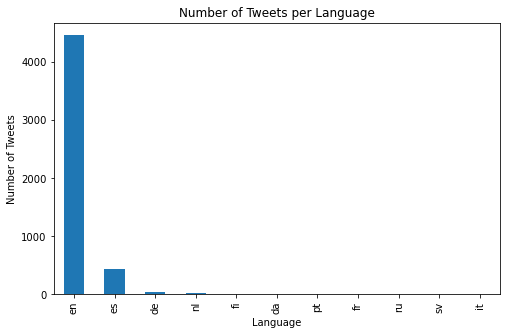

In [12]:
tweets_per_language = pd.Series(tweets['Tweet language (ISO 639-1)'].value_counts())

tweets_per_language.plot(kind='bar', 
                         figsize=(8,5), 
                         title="Number of Tweets per Language",
                         xlabel="Language",
                         ylabel="Number of Tweets",
                        )

In [13]:
tweets_per_language

en    4450
es     440
de      48
nl      16
fi      12
da       8
pt       6
fr       6
ru       6
sv       2
it       1
Name: Tweet language (ISO 639-1), dtype: int64

In [29]:
tweets["Tweet content"][tweets['Tweet language (ISO 639-1)']=="ru"].values

array(['Из вчерашних отчетов после закрытия интересные: $EA $FOSL $DIS $BUFF',
       'RT @aradchenko1: шаг 1 посмотреть https://t.co/l8opOj6pds\nшаг 2 ахереть\nшаг 3 открыть терминал и купить $EA  (сегодня отчет после клоуза)',
       'Диванная аналитика сработала $EA + 6% https://t.co/YJbqR7GkcK',
       'RT @aradchenko1: шаг 1 посмотреть https://t.co/l8opOj6pds\nшаг 2 ахереть\nшаг 3 открыть терминал и купить $EA  (сегодня отчет после клоуза)',
       'шаг 1 посмотреть https://t.co/l8opOj6pds\nшаг 2 ахереть\nшаг 3 открыть терминал и купить $EA  (сегодня отчет после клоуза)',
       'Кто хочет поиграть? $EA $ATVI $TTWO'], dtype=object)

Twitter language is messy. The dataset contains 11 unique languages. Getting rid of URLs and user names because they don't add anything to the context of the text. Usernames usually follow an "@" symbol and retweets have an "RT" tag before the twitter handle. URLs are usually shortened code that redirect to another twitter page. I will be keeping the tickers and hashtags as they can contain information about the tweet. Preprocessing could be difficult because some tweets use symbols to replace a letter in a word (eg. J@ck, \\$ea$on).

[Regex cheatsheet](https://quickref.me/regex)

In [93]:
# TODO: put into function
tweets["cleaned"] = tweets["Tweet content"].replace(r"https:\/\/t.co/[a-zA-Z0-9]+", "", regex=True)
tweets["cleaned"] = tweets["cleaned"].replace(r"\s?RT\s*@[a-zA-z0-9]*:\s", "", regex=True)
tweets["cleaned"] = tweets["cleaned"].replace(r"(\s|^|\W)@[\w]*\)?", "", regex=True)   
# TODO: remove double spaces, trailing and starting spaces

# check
for tweet in tweets[["Tweet content", "cleaned"]].values:
    print(tweet)
    print()

['#VR hardware is here, but robust game lineup isn’t. https://t.co/2himdl5vxI $EA $MSFT $SNE #E3 #tech https://t.co/mHoyRvQthn'
 '#VR hardware is here, but robust game lineup isn’t.  $EA $MSFT $SNE #E3 #tech ']

['OVAS Pacific Biosciences of California Inc. Exchange\nhttps://t.co/VeHGAIzbbs\n\n$OVAS $QRVO $EA $TMF  #invest #stock'
 'OVAS Pacific Biosciences of California Inc. Exchange\n\n\n$OVAS $QRVO $EA $TMF  #invest #stock']

['$EA Rf xcw€•£*cc. Ze,*$*3,r#43€•¢t,😠°==™©•√'
 '$EA Rf xcw€•£*cc. Ze,*$*3,r#43€•¢t,😠°==™©•√']

['FXA CurrencyShares British Pound Sterling Trust Summary\nhttps://t.co/izmw6jetQr\n\n$FXA $IVOB $EA $HTS  #nasdaq #investing'
 'FXA CurrencyShares British Pound Sterling Trust Summary\n\n\n$FXA $IVOB $EA $HTS  #nasdaq #investing']

['CBT Cabot Corp. Yield\nhttps://t.co/0kL5KBx2QD\n\n$CBT $EA $SQQQ $HXU.TO  #stockmarket #nasdaq'
 'CBT Cabot Corp. Yield\n\n\n$CBT $EA $SQQQ $HXU.TO  #stockmarket #nasdaq']

['Listen to $teelakejake - G$U$ $EA$UN - 05 Is It Real (prod. S

 " Need your thoughts. What do you think about playing gap down on $EA? I rode up and long $ATVI and think it's a pair trade"]

['Unusual Call Activity https://t.co/P9HAzFR1WH    $HTZ $XLU $MDLZ $IYR $V $MU $EWZ $HD $RLYP $BAX $SPX $COST $WMT $MYL $SDRL $EA $ANF $BAC'
 'Unusual Call Activity     $HTZ $XLU $MDLZ $IYR $V $MU $EWZ $HD $RLYP $BAX $SPX $COST $WMT $MYL $SDRL $EA $ANF $BAC']

['RT @MarioBaloteIIi: 🔥GLOW $EA$ON🔥 TEAR$💦 EP - SoundCloud Listen to 🔥GLOW $EA$ON🔥 TEAR$💦 EP by @ArchieAccent  #np on #SoundCloud\nhttps://t.c…'
 '🔥GLOW $EA$ON🔥 TEAR$💦 EP - SoundCloud Listen to 🔥GLOW $EA$ON🔥 TEAR$💦 EP by  #np on #SoundCloud\nhttps://t.c…']

['RT @_jvggy: Listen to GLOW $EA$ON TEAR$ EP - @ArchieAccent  https://t.co/6SqT2OBh3o'
 'Listen to GLOW $EA$ON TEAR$ EP -  ']

['Scan results - Hammer Candlestick today: $ZG $Z $DLTR $DISCA $CPT $K $LII $KR $EA $PLD ... https://t.co/eKE2xV8nQm'
 'Scan results - Hammer Candlestick today: $ZG $Z $DLTR $DISCA $CPT $K $LII $KR $EA $PLD ... ']

['PSA Last 

['$EA and $CSIQ short ideas from earlier went for peanuts'
 '$EA and $CSIQ short ideas from earlier went for peanuts']

['@Dragontraders add to $EA position but may 20 $74p 1.5 entry'
 ' add to $EA position but may 20 $74p 1.5 entry']

['$EA short 74.25' '$EA short 74.25']

['RT @SaiyanTrader90: Added  $EA SS  $74.57' 'Added  $EA SS  $74.57']

['Ideas for today (intraday):\n\n$EA      short\n\n$CSIQ    short\n\n$FOSL    long'
 'Ideas for today (intraday):\n\n$EA      short\n\n$CSIQ    short\n\n$FOSL    long']

["$EA:US 'Star Wars Battlefront' powers EA's profit, revenue beat #ELECTRONIC ARTS INC  https://t.co/RFoP3DXYe0 #NASDAQ"
 "$EA:US 'Star Wars Battlefront' powers EA's profit, revenue beat #ELECTRONIC ARTS INC   #NASDAQ"]

['$EA, $JWN, $A and even some $TGT. Nice, quick and efficient. DONE! https://t.co/wFrOAR5cEd'
 '$EA, $JWN, $A and even some $TGT. Nice, quick and efficient. DONE! ']

['Technical action by S&amp;P 500 stocks to10:15: Mixed. Breakouts: $CAC, $PM, $EA. Breakdowns $

 'Feel the sensation of $SNE Sony PlayStation VR  #PSVR\n #VirtualReality $AAP…']

['Feel the sensation of $SNE Sony PlayStation VR https://t.co/jY00emtabT #PSVR\nhttps://t.co/1oRJMDcrwN #VirtualReality $AAPL $FB $MSFT $EA'
 'Feel the sensation of $SNE Sony PlayStation VR  #PSVR\n #VirtualReality $AAPL $FB $MSFT $EA']

['#ElectronicArts Mass Effect Andromeda Release: What We Know &amp; Think We Know. Read more: https://t.co/SsDaBYN336 $EA'
 '#ElectronicArts Mass Effect Andromeda Release: What We Know &amp; Think We Know. Read more:  $EA']

['Battlefield 1 trailer features cavalry, Zeppelins $EA https://t.co/zn5MX2ntkr https://t.co/R3bwLLQmyW'
 'Battlefield 1 trailer features cavalry, Zeppelins $EA  ']

['Battlefield 1 trailer features cavalry, Zeppelins $EA https://t.co/qOKOuvjdJi https://t.co/Z4iDj2Vs6p'
 'Battlefield 1 trailer features cavalry, Zeppelins $EA  ']

['Dichotomy. $EA goes back to World War I for Battlefield while $ATVI goes forward to space with COD: Infinite Warfare htt

 'Listen to Flowers by Dally $ea #np on #SoundCloud ']

['RT @_DallyC: Listen to Flowers by Dally $ea #np on #SoundCloud https://t.co/xEG7hqY0k6'
 'Listen to Flowers by Dally $ea #np on #SoundCloud ']

['$MBLY $EA:\n\nTwo Movers inside Analysts Radar: Mobileye N.V. (NYSE:MBLY …:\n\nhttps://t.co/xYNiBRb7QW'
 '$MBLY $EA:\n\nTwo Movers inside Analysts Radar: Mobileye N.V. (NYSE:MBLY …:\n\n']

['Listen to Flowers by Dally $ea #np on #SoundCloud https://t.co/xEG7hqY0k6'
 'Listen to Flowers by Dally $ea #np on #SoundCloud ']

['RT @JeaYu21: $UA $EA $WBA $TGT  chart https://t.co/BiOCVzI0x4'
 '$UA $EA $WBA $TGT  chart ']

['Commented on Did Glu Mobile Finally Deliver A Winner? https://t.co/xuBsMRP2V9 $EA $GLUU'
 'Commented on Did Glu Mobile Finally Deliver A Winner?  $EA $GLUU']

['$EA:\n\nElectronic Arts Inc. (NASDAQ:EA) Closes +2.87% For the Session:\n\nhttps://t.co/Rr7QDgInnE'
 '$EA:\n\nElectronic Arts Inc. (NASDAQ:EA) Closes +2.87% For the Session:\n\n']

['#miitomo bringing in $280k a wee